
# Proyecto Big Data — **Predicción de Rotación de Empleados** (Informe Final)
**Autora:** Beatriz Velayos  
**Bootcamp:** KeepCoding — XV Edición  
**Fecha:** 2025-08-11

> Este informe resume el objetivo de negocio, los datos y su calidad, la arquitectura, el ETL, el EDA, el modelado tradicional y con DL, la comparación de resultados, los KPIs para negocio y las conclusiones con próximos pasos.



## 1. Resumen ejecutivo
- **Objetivo:** Predecir *Attrition* (abandono) de empleados para priorizar acciones de retención.
- **Resultado:** Se evaluaron modelos ML (LogReg, RandomForest) y un MLP (DL). Se seleccionó el modelo óptimo con **umbral operativo** para maximizar F1/recall.
- **Impacto:** Identificación de factores clave (ej. `OverTime`, `Income`, *engagement*). KPI de negocio con tasas por **JobRole**, **OverTime**, **bandas salariales** y **antigüedad**.



## 2. Definición del problema
- **Tipo:** Clasificación binaria (Attrition: Sí/No).
- **Métrica principal:** ROC-AUC + F1 (por desbalanceo ~16% de clase positiva).
- **Uso en negocio:** Score de salida y bandera (según umbral) para campañas de retención, priorización de manager HR y política de horas extra.



## 3. Datos y calidad
- **Fuente 1:** `WA_Fn-UseC_-HR-Employee-Attrition.csv` (RRHH).  
- **Fuente 2:** `encuesta_clima.csv` (clima laboral; sintética/real).
- **Clave de unión:** `EmployeeNumber`.
- **Validación:** Nulos y duplicados en clave; fracción de nulos por columna; **status: PASS**.


In [10]:
# Cargar resúmenes de calidad/ETL si existen
import json, os, pandas as pd, textwrap

paths = {
    "quality": "/output/metrics/quality_report.json",
    "etl": "/output/metrics/etl_metrics.json"
}
for k,p in paths.items():
    if os.path.isfile(p):
        print(f"== {k.upper()} -> {p}")
        print(open(p).read()[:1000] + ("..." if len(open(p).read())>1000 else ""))
    else:
        print(f"(Aviso) No encontrado: {p}")


== QUALITY -> /output/metrics/quality_report.json
{
  "timestamp": "2025-08-11T08:35:53.769985Z",
  "inputs": {
    "input1": "/data/raw/WA_Fn-UseC_-HR-Employee-Attrition.csv",
    "input2": "/data/raw/encuesta_clima.csv"
  },
  "key": "EmployeeNumber",
  "max_null_frac": 0.25,
  "checks": {
    "null_key": {
      "input1_nulls": 0,
      "input2_nulls": 0
    },
    "duplicates": {
      "input1_duplicates": 0,
      "input2_duplicates": 0
    },
    "nulls_fraction": {
      "input1": {
        "Age": {
          "nulls": 0,
          "frac": 0.0
        },
        "Attrition": {
          "nulls": 0,
          "frac": 0.0
        },
        "BusinessTravel": {
          "nulls": 0,
          "frac": 0.0
        },
        "DailyRate": {
          "nulls": 0,
          "frac": 0.0
        },
        "Department": {
          "nulls": 0,
          "frac": 0.0
        },
        "DistanceFromHome": {
          "nulls": 0,
          "frac": 0.0
        },
        "Education": {
       


## 4. Arquitectura (resumen)
- **Docker Compose:** Jupyter + Spark (master/worker) + (opcional) PostgreSQL.
- **Ingesta:** Volúmenes `data/` y `output/` montados.
- **Procesado:** PySpark para ETL y métricas; scikit-learn/TensorFlow para modelos.
- **Visualización:** Notebook + exportables (CSV/PNG) y/o Power BI.

**Diagrama (alto nivel):**
```
[CSV RRHH]     [Encuesta Clima]
     \             /
      \           /         +------------------+
       \         /          |  JUPYTER         |
       [ PySpark ETL ] --->  |  - ETL/Métricas  |--> /output/metrics, /output/plots, /output/bi
                |            |  - ML / DL       |--> /output/models
         /data/processed     +------------------+
```



## 5. ETL (Spark) y *feature engineering*
- **Join** inner por `EmployeeNumber`.
- Limpieza y normalización de strings.
- **Features creadas:**  
  - `attrition_label` (Yes→1, No→0)  
  - `overtime_flag` (Yes→1, No→0)  
  - `income_yearly = MonthlyIncome * 12`  
  - `tenure_ratio = YearsInCurrentRole / (TotalWorkingYears + eps)`
- **Salida:** Parquet en `/data/processed/employee_attrition.parquet`.



## 6. EDA (resumen)
- Clase positiva ~16% → **desbalanceo moderado**.
- **OverTime=Yes** y **ingresos bajos** asocian mayor attrition.
- Satisfacción/engagement menores elevan la tasa.

A continuación, se muestran KPIs de negocio exportados y gráficos clave (si existen en `/output/bi` y `/output/plots`).

In [12]:
# KPIs exportados para dashboard
import pandas as pd, os

bi_files = [
    "/output/bi/kpi_overview.csv",
    "/output/bi/attrition_by_jobrole.csv",
    "/output/bi/attrition_by_department.csv",
    "/output/bi/attrition_by_overtime.csv",
    "/output/bi/attrition_by_income_band.csv",
    "/output/bi/attrition_by_tenure_band.csv",
]
for f in bi_files:
    if os.path.isfile(f):
        display(pd.read_csv(f).head())
    else:
        print("(Aviso) No encontrado:", f)


,rows,attrition_positive,attrition_rate
0,1470,237,0.161224


,JobRole,n,attrition_rate
0,Sales Representative,83,0.397590
1,Laboratory Technician,259,0.239382
2,Human Resources,52,0.230769
3,Sales Executive,326,0.174847
4,Research Scientist,292,0.160959


,Department,n,attrition_rate
0,Sales,446,0.206278
1,Human Resources,63,0.190476
2,Research & Development,961,0.138398


,OverTime,n,attrition_rate
0,Yes,416,0.305288
1,No,1054,0.104364


,income_band,n,attrition_rate
0,40–60k,307,0.143322
1,60–80k,249,0.088353
2,80–100k,102,0.137255
3,<40k,442,0.269231
4,>=100k,370,0.102703


,tenure_band,n,attrition_rate
0,0–2,215,0.348837
1,2–5,365,0.180822
2,5–10,524,0.110687
3,>=10,366,0.103825


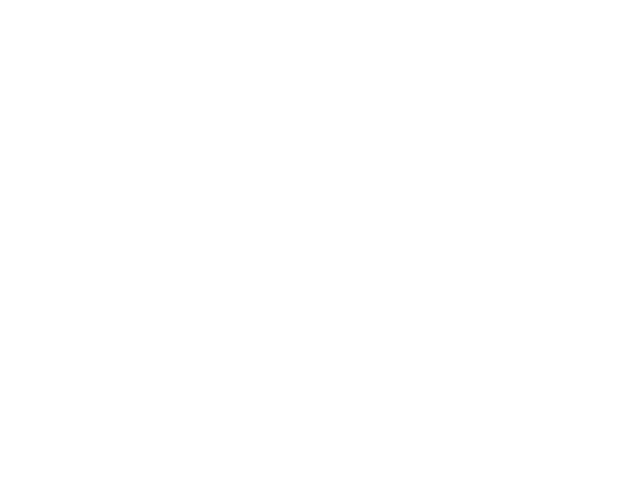

(Aviso) Plot no encontrado: /output/plots/attrition_by_jobrole_top10.png
(Aviso) Plot no encontrado: /output/plots/attrition_by_overtime.png


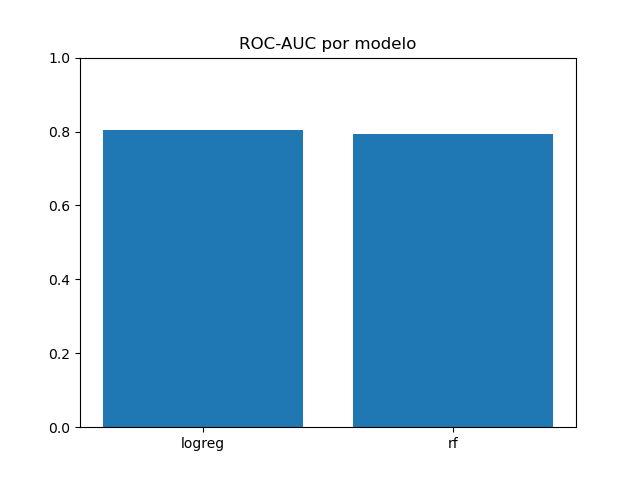

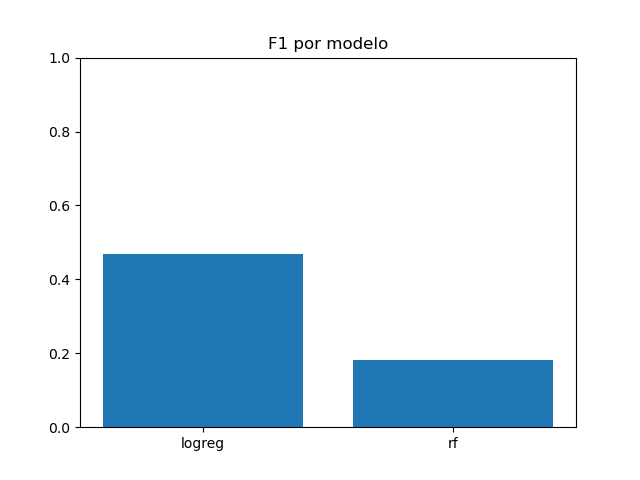

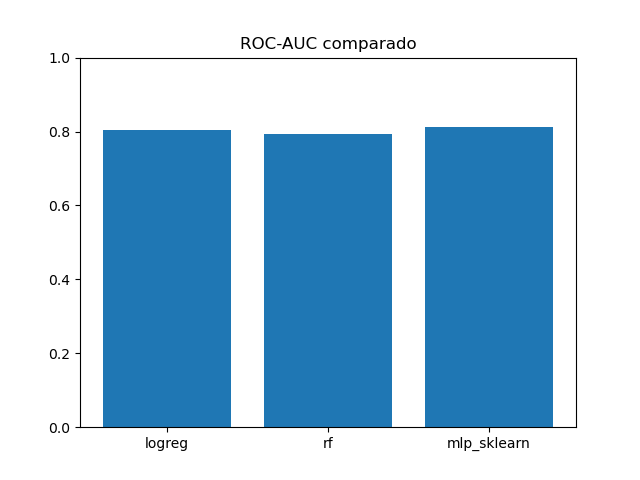

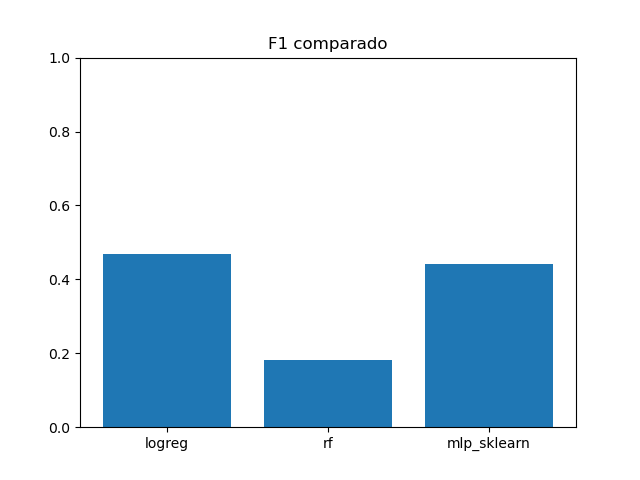

In [14]:
# Mostrar plots si existen
import os, IPython
plot_paths = [
    "/output/plots/attrition_jobrole.png",
    "/output/plots/attrition_by_jobrole_top10.png",
    "/output/plots/attrition_by_overtime.png",
    "/output/plots/roc_auc_por_modelo.png",
    "/output/plots/f1_por_modelo.png",
    "/output/plots/model_compare_auc.png",
    "/output/plots/model_compare_f1.png",
]
for p in plot_paths:
    if os.path.isfile(p):
        display(IPython.display.Image(filename=p))
    else:
        print("(Aviso) Plot no encontrado:", p)



## 7. Modelado y comparación
- **ML tradicional:** Logistic Regression (balancing), Random Forest.
- **DL:** MLP (scikit-learn o Keras).
- **Métricas:** Accuracy, F1, ROC-AUC, PR-AUC.

Se selecciona el **mejor modelo** y se ajusta **umbral operativo** (F1/recall según negocio).


In [15]:
# Cargar métricas y umbrales guardados
import json, os, pandas as pd

def load_json(p):
    if os.path.isfile(p):
        with open(p) as f: 
            return json.load(f)
    return {}

baseline = load_json("/output/metrics/model_baseline.json")
compare  = load_json("/output/metrics/model_compare.json") or baseline
thr_lr   = load_json("/output/metrics/threshold_tuning.json")
thr_mlp  = load_json("/output/metrics/threshold_tuning_mlp.json")

print("Baseline:", baseline if baseline else "(no encontrado)")
print("\nComparativa:", compare if compare else "(no encontrado)")
print("\nUmbral LR:", thr_lr if thr_lr else "(no encontrado)")
print("Umbral MLP:", thr_mlp if thr_mlp else "(no encontrado)")

# Tabla resumen si existe comparativa
if compare:
    rows = []
    for m, metrics in compare.items():
        rows.append({"model": m, **metrics})
    display(pd.DataFrame(rows).sort_values("roc_auc", ascending=False))


Baseline: {'logreg': {'accuracy': 0.7619047619047619, 'f1': 0.4696969696969697, 'roc_auc': 0.8052373158756138}, 'rf': {'accuracy': 0.8469387755102041, 'f1': 0.18181818181818182, 'roc_auc': 0.7932207769833749}}

Comparativa: {'logreg': {'accuracy': 0.7619047619047619, 'f1': 0.4696969696969697, 'roc_auc': 0.8052373158756138}, 'rf': {'accuracy': 0.8469387755102041, 'f1': 0.18181818181818182, 'roc_auc': 0.7932207769833749}, 'mlp_sklearn': {'accuracy': 0.8707482993197279, 'f1': 0.4411764705882353, 'roc_auc': 0.8126453613575675}}

Umbral LR: {'best_threshold_by_f1': 0.705193598441277, 'best_f1': 0.5168539325842697}
Umbral MLP: {'best_threshold_by_f1': 0.27992078094205797, 'best_f1': 0.5384615384615384}


,model,accuracy,f1,roc_auc
2,mlp_sklearn,0.870748,0.441176,0.812645
0,logreg,0.761905,0.469697,0.805237
1,rf,0.846939,0.181818,0.793221



### 7.1 Política de decisión (umbral)
- Umbral seleccionado por **máximo F1** (*o* por recall objetivo si negocio prioriza capturar más casos).
- Se recomienda monitorizar F1/precision/recall mensual y recalibrar.

**Salida de inferencia:** score ∈ [0,1] + predicción binaria según umbral.  
**Ejecución sugerida:** lote semanal (o diaria) y aviso a managers de equipos con mayor tasa prevista.



## 8. KPIs y recomendación de negocio
- Tasa por **JobRole** y **OverTime**: priorizar **revisión de horas extra** y **planes de compensación**.
- Bandas **income** y **tenure**: diseñar **políticas de retención** específicas por tramo.
- Usar la **bandera de riesgo** del modelo para priorizar entrevistas stay-interview.



## 9. Conclusiones y *lessons learned*
- Modelos ML tradicionales pueden rendir tan bien o mejor que DL con buen preprocesado.
- La **calidad de datos** y el **umbral** impactan más que micro-ajustes en hiperparámetros.
- Métricas deben leerse junto al **coste/beneficio** (falsos positivos vs falsos negativos).



## 10. Próximos pasos
- Enriquecer features (rotaciones internas, ausencias, rendimiento histórico).
- Ajustar umbral por **coste esperado** (optimización de utilidad). 
- Validación temporal (*backtesting*) y **monitoring** (drift, estabilidad).
- (Opcional) Despliegue en API/Batch + dashboard en Power BI.



## Apéndice A — Reproducibilidad
- **Arranque:** `docker compose up -d`  
- **Datos:** `data/raw/` → ETL → `data/processed/`  
- **Scripts:** `scripts/etl_attrition.py`  
- **Notebooks:** `01_EDA_Attrition.ipynb`, `02_Modelado_Baseline.ipynb`, `03_Modelado_DL.ipynb`, `05_Dashboard_KPIs.ipynb`, `99_Informe_Final.ipynb`  
- **Resultados:** `output/metrics/`, `output/models/`, `output/plots/`, `output/bi/`
